In [1]:
import pandas as pd

import seaborn as sns

sns.set_context("talk")
import matplotlib.pyplot as plt
import statsmodels

import statsmodels.formula.api as smf
import numpy as np

plt.style.use("ggplot")

In [2]:
data=pd.read_csv('clean_data/final_dataset.csv')
data[['income_census','pop_census']]=np.log(data[['income_census','pop_census']])

In [3]:
data.columns
y = "pov_saipe_2010"
x = [
    "pop_census",
    "nhwrate",
    "blkrate",
    "asianrate",
    "hisprate",
    "nativerate",
    "state_mormon",
    "altitude",
    "mormon",
]

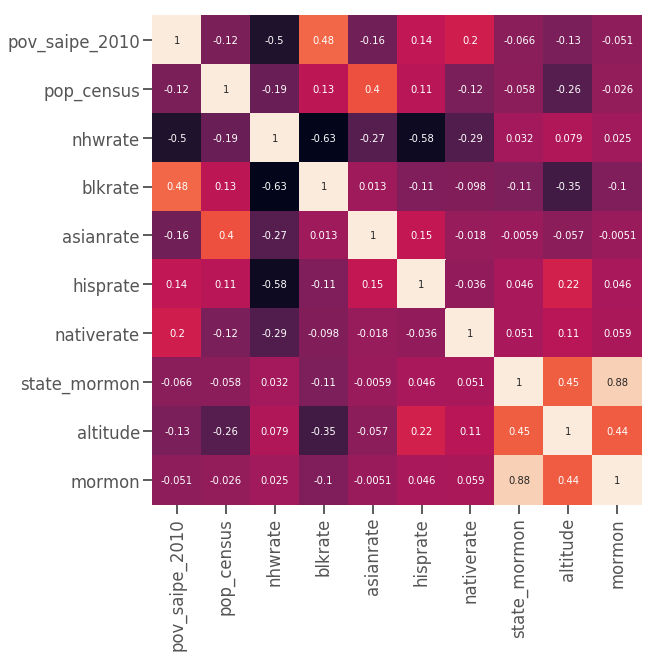

In [4]:
plt.figure(figsize=(9,9))
sns.heatmap(data[[y]+x].corr(),annot=True,square=True,cbar=False)

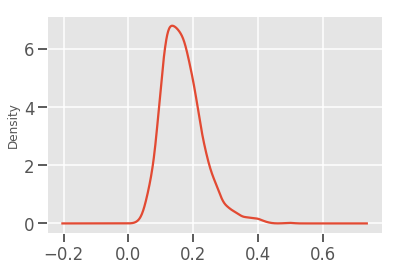

In [5]:
#lognormal
data['pov_saipe_2010'].plot.kde()

In [6]:
data.pov_saipe_2010.describe()

count    3126.000000
mean        0.167565
std         0.062179
min         0.031000
25%         0.123000
50%         0.159000
75%         0.202000
max         0.501000
Name: pov_saipe_2010, dtype: float64

In [7]:
import statsmodels.api as sm


def regress(
    x,
    y,
    model="ols",
    plot=False,
    summary=False,
    show_nonsignificant=False,
    data=data,
    log=False,
):
    # Weighted regression due to different pop size in each county. Lower pops will be noisier.
    if log:
        expr = f"np.log({y})~" + "+".join(x)
        logiflog = np.log
    else:
        expr = f"({y})~" + "+".join(x)
        logiflog = lambda x: x
    if model == "glm":
        ret = smf.glm(
            expr,
            data=data,
            family=sm.families.Gaussian(link=sm.families.links.log()),
            var_weights=data.pop_census,
        ).fit()
    elif model == "wls":
        ret = smf.ols(expr, data=data).fit()
    else:
        ret = smf.wls(expr, data=data, weights=data["pop_census"]).fit()
    if summary:
        display(ret.summary())
    if plot:
        if model == "glm":
            pred = logiflog(ret.predict(data[x]).squeeze())
        else:
            pred = logiflog(ret.predict(data[x]).squeeze())
        display(plt.scatter(data[y], pred))
        max_y = max(data[y])
        min_y = min(data[y])
        plt.plot([min_y, max_y], [min_y, max_y], c="blue")
    df = pd.concat([ret.params, ret.pvalues], axis=1)

    df.columns = ["coefficients", "pvalue"]
    df["pvalue"] = df["pvalue"].round(3)
    df["pvalue"] = np.where(
        df.pvalue < 0.05, df.pvalue.astype(str) + "*", df.pvalue.astype(str)
    )
    if not show_nonsignificant:
        df = df[df.pvalue.str.contains("\*")]

    mean_frame = data[x].mean().to_frame().T
    if "state" in x:
        mean_frame["state"] = "Utah"
    mean_predicted = ret.predict(mean_frame).values
    display(f"Baseline value: {np.round(mean_predicted,2).squeeze()}")

    for var in df.index:
        if var != "Intercept" and "state[" not in var:
            df.loc[var, "var_max_value"] = data[var].max()
            df.loc[var, "var_mean_value"] = data[var].mean()
            df.loc[var, "effect_mean_to_max"] = (
                ret.predict(mean_frame.assign(**{var: data[var].max()})).values
                - mean_predicted
            )
    # df["effect_pc"] = 100 * (df.effect_mean_to_max) / mean_predicted
    df = df.round(3)

    return df, ret


t, mod = regress(x, y, model="glm", log=False)
t

'Baseline value: 0.16'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,-1.417,0.0*,NaN,NaN,NaN
pop_census,-0.027,0.0*,16.078,10.225,-0.024
blkrate,0.889,0.006*,0.861,0.089,0.162
asianrate,-4.313,0.0*,0.522,0.011,-0.145
nativerate,0.806,0.021*,0.889,0.017,0.167
state_mormon,-0.470,0.005*,0.690,0.022,-0.044
altitude,-0.000,0.0*,4008.285,424.280,-0.029
mormon,0.000,0.006*,1007.860,21.801,0.072


In [8]:
#Substract income effect from poverty
df,mod=regress(['income_census'],y,model='ols')
data['resid_pov']=mod.resid
y2='resid_pov'

'Baseline value: 0.17'

In [9]:
data.resid_pov.describe()

count    3126.000000
mean       -0.001460
std         0.039244
min        -0.118908
25%        -0.028195
50%        -0.005809
75%         0.019775
max         0.206969
Name: resid_pov, dtype: float64

In [10]:
# #Keep state as per BIC and AIC
# df,mod=regress(x,y2,model='glm')
# df
# #???? (weird numerical error)

In [11]:
df,mod=regress(x,y2,model='ols',)
df

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,-0.091,0.007*,NaN,NaN,NaN
pop_census,0.006,0.0*,16.078,10.225,0.034
blkrate,0.138,0.0*,0.861,0.089,0.106
asianrate,0.144,0.003*,0.522,0.011,0.073
nativerate,0.127,0.001*,0.889,0.017,0.111
altitude,0.000,0.0*,4008.285,424.280,0.037
mormon,-0.000,0.0*,1007.860,21.801,-0.058


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     181.4
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          2.46e-277
Time:                        15:55:18   Log-Likelihood:                 6345.3
No. Observations:                3126   AIC:                        -1.267e+04
Df Residuals:                    3116   BIC:                        -1.261e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0729      0.035     -2.108      0.035      -0.141      -0.005
pop_census       0.0055      0.000     12.094      0.000       0.005       0.006
nhwrate         -0.0063      0.035     -0.183      0.855      -0.074       0.061
blkrate          0.1241      0.034      3.605      0.000       0.057       0.192
asianrate        0.1234      0.050      2.486      0.013       0.026       0.221
hisprate         0.0401      0.035      1.161      0.246      -0.028       0.108
nativerate       0.1146      0.038      3.018      0.003       0.040       0.189
state_mormon    -0.0112      0.017     -0.666      0.505      -0.044       0.022
altitude      1.073e-05   1.46e-06      7.347      0.000    7.87e-06    1.36e-05
mormon       -5.831e-05   1.41e-05     -4.127      0.000    -8.6e-05   -3.06e-05
==============================================================================
Omnibus:                      339.693   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.783
Skew:                           0.690   Prob(JB):                    1.21e-149
Kurtosis:                       4.834   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,-0.073,0.035*,NaN,NaN,NaN
pop_census,0.005,0.0*,16.078,10.225,0.032
blkrate,0.124,0.0*,0.861,0.089,0.096
asianrate,0.123,0.013*,0.522,0.011,0.063
nativerate,0.115,0.003*,0.889,0.017,0.100
altitude,0.000,0.0*,4008.285,424.280,0.038
mormon,-0.000,0.0*,1007.860,21.801,-0.057


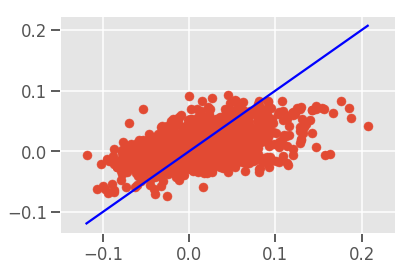

In [12]:
#Not much difference from plain OLS
df,mod=regress(x,y2,model='wls',plot=True,summary=True)
df

In [13]:
target = data.query('county=="Salt Lake"')[x]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0]
        - mod.predict(target).values[0],
    }
)
# Baseline is 0.119 because it's not the residual, but the original variable

predicted              -0.017001
baseline                0.137000
no_mormons              0.017590
no_mormons-predicted    0.034591
dtype: float64

# Effect of mormon
After controlling for income, the effect of mormonism is similar to the effect of everything else: tiny. Full mormonisation would yield negligible gains.

But what if? Mormon->Income?

'Baseline value: 10.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,9.767,0.0*,NaN,NaN,NaN
mormon,-0.000,0.002*,1007.860,21.801,-0.127
nhwrate,0.275,0.0*,1.000,0.788,0.058
blkrate,-0.168,0.0*,0.861,0.089,-0.130
asianrate,3.753,0.0*,0.522,0.011,1.918
nativerate,-0.278,0.0*,0.889,0.017,-0.242


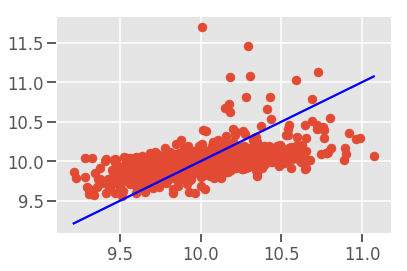

In [14]:
df,mod=regress(['mormon',"nhwrate","blkrate","asianrate","nativerate"],'income_census',plot=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     181.4
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          2.46e-277
Time:                        15:55:19   Log-Likelihood:                 6345.3
No. Observations:                3126   AIC:                        -1.267e+04
Df Residuals:                    3116   BIC:                        -1.261e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0729      0.035     -2.108      0.035      -0.141      -0.005
pop_census       0.0055      0.000     12.094      0.000       0.005       0.006
nhwrate         -0.0063      0.035     -0.183      0.855      -0.074       0.061
blkrate          0.1241      0.034      3.605      0.000       0.057       0.192
asianrate        0.1234      0.050      2.486      0.013       0.026       0.221
hisprate         0.0401      0.035      1.161      0.246      -0.028       0.108
nativerate       0.1146      0.038      3.018      0.003       0.040       0.189
state_mormon    -0.0112      0.017     -0.666      0.505      -0.044       0.022
altitude      1.073e-05   1.46e-06      7.347      0.000    7.87e-06    1.36e-05
mormon       -5.831e-05   1.41e-05     -4.127      0.000    -8.6e-05   -3.06e-05
==============================================================================
Omnibus:                      339.693   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              685.783
Skew:                           0.690   Prob(JB):                    1.21e-149
Kurtosis:                       4.834   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: -0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,-0.073,0.035*,NaN,NaN,NaN
pop_census,0.005,0.0*,16.078,10.225,0.032
blkrate,0.124,0.0*,0.861,0.089,0.096
asianrate,0.123,0.013*,0.522,0.011,0.063
nativerate,0.115,0.003*,0.889,0.017,0.100
altitude,0.000,0.0*,4008.285,424.280,0.038
mormon,-0.000,0.0*,1007.860,21.801,-0.057


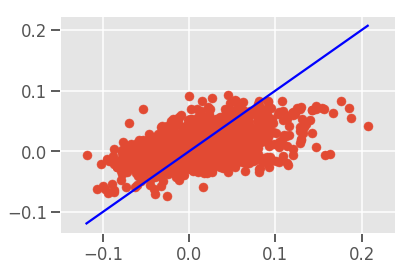

In [15]:
x2=x+['state']
#Keep state as per BIC and AIC
df,mod=regress(x,y2,model='wls',plot=True,summary=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              resid_pov   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     39.70
Date:                Mon, 31 Dec 2018   Prob (F-statistic):          4.94e-324
Time:                        15:55:19   Log-Likelihood:                 6562.1
No. Observations:                3126   AIC:                        -1.301e+04
Df Residuals:                    3067   BIC:                        -1.265e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0712      0.049      1.463      0.144      -0.024       0.167
state[T.Alaska]                  -0.0398      0.009     -4.675      0.000      -0.056      -0.023
state[T.Arizona]                 -0.0074      0.009     -0.821      0.412      -0.025       0.010
state[T.Arkansas]                -0.0045      0.005     -0.893      0.372      -0.015       0.005
state[T.California]               0.0022      0.006      0.368      0.713      -0.010       0.014
state[T.Colorado]                -0.0105      0.007     -1.571      0.116      -0.024       0.003
state[T.Connecticut]              0.0028      0.011      0.244      0.807      -0.019       0.025
state[T.Delaware]                -0.0257      0.018     -1.454      0.146      -0.060       0.009
state[T.District of Columbia]     0.0843      0.030      2.789      0.005       0.025       0.143
state[T.Florida]                  0.0081      0.005      1.541      0.123      -0.002       0.019
state[T.Georgia]                 -0.0057      0.004     -1.308      0.191      -0.014       0.003
state[T.Hawaii]                  -0.0911      0.022     -4.120      0.000      -0.134      -0.048
state[T.Idaho]                   -0.0119      0.006     -1.910      0.056      -0.024       0.000
state[T.Illinois]                -0.0193      0.005     -3.931      0.000      -0.029      -0.010
state[T.Indiana]                 -0.0212      0.005     -4.194      0.000      -0.031      -0.011
state[T.Iowa]                    -0.0244      0.005     -4.915      0.000      -0.034      -0.015
state[T.Kansas]                  -0.0288      0.005     -5.799      0.000      -0.039      -0.019
state[T.Kentucky]                 0.0172      0.005      3.617      0.000       0.008       0.027
state[T.Louisiana]               -0.0069      0.005     -1.318      0.188      -0.017       0.003
state[T.Maine]                   -0.0056      0.008     -0.656      0.512      -0.022       0.011
state[T.Maryland]                -0.0145      0.007     -2.021      0.043      -0.029      -0.000
state[T.Massachusetts]            0.0189      0.009      2.104      0.035       0.001       0.036
state[T.Michigan]                -0.0025      0.005     -0.488      0.625      -0.013       0.008
state[T.Minnesota]               -0.0280      0.005     -5.484      0.000      -0.038      -0.018
state[T.Mississippi]             -0.0042      0.005     -0.838      0.402      -0.014       0.006
state[T.Missouri]                -0.0090      0.005     -1.881      0.060      -0.018       0.000
state[T.Montana]                 -0.0100      0.006     -1.698      0.090      -0.021       0.002
state[T.Nebraska]                -0.0321      0.005     -6.256      0.000      -0.042      -0.022
state[T.Nevada]                  -0.0220     

'Baseline value: 0.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
state[T.Alaska],-0.040,0.0*,NaN,NaN,NaN
state[T.District of Columbia],0.084,0.005*,NaN,NaN,NaN
state[T.Hawaii],-0.091,0.0*,NaN,NaN,NaN
state[T.Illinois],-0.019,0.0*,NaN,NaN,NaN
state[T.Indiana],-0.021,0.0*,NaN,NaN,NaN
state[T.Iowa],-0.024,0.0*,NaN,NaN,NaN
state[T.Kansas],-0.029,0.0*,NaN,NaN,NaN
state[T.Kentucky],0.017,0.0*,NaN,NaN,NaN
state[T.Maryland],-0.014,0.043*,NaN,NaN,NaN
state[T.Massachusetts],0.019,0.035*,NaN,NaN,NaN


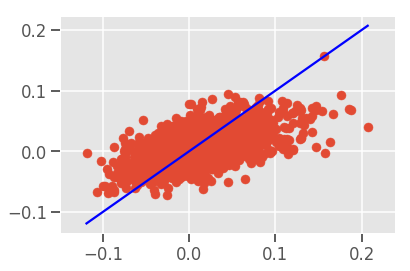

In [16]:
df,mod=regress(x2,y2,model='wls',plot=True,summary=True)
df

In [17]:
target = data.query('county=="Salt Lake"')[x2]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y2].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0]
        - mod.predict(target).values[0],
    }
)

predicted              -0.021637
baseline                0.137000
no_mormons              0.015313
no_mormons-predicted    0.036950
dtype: float64

# Again, negligible
Final prediction from linear models: Full 1000->0 demormonisation would lead to a rise in poverty of 3.7 percentage points in Utah

# Let's try catboost

### With income (on poverty)

In [18]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor,Dataset
from lightgbm import plot_importance

ITERATIONS=100
def get_bayes_tuner(cat_feat=[]):
    search_space = {
 
        "num_leaves":(10,40),
        "min_child_samples":(5,50),
        "learning_rate":(0.01,0.5,"uniform"),
        "n_estimators":(10,500),
        "min_split_gain":(0.,1.,"uniform"),
        "colsample_bytree":(0.5,0.8,1)

    }
    return BayesSearchCV(
        estimator=LGBMRegressor(n_jobs=6),
        search_spaces=search_space,
        cv=KFold(n_splits=20, shuffle=True, random_state=42),
        n_jobs=2,
        n_iter=ITERATIONS,
        verbose=3,
        refit=True,
        random_state=42,
        scoring="r2",
        fit_params={'categorical_feature':cat_feat}
    )

In [19]:
data['state_factor'],factor_array=pd.factorize(data.state)

In [20]:
x3=x2[::1]
x3.remove('state')
x3.append('state_factor')
x3.append('income_census')

In [21]:
cat_pos = np.where(data[x3].dtypes == int)[0].tolist()
pool = Dataset(
    data=data[x3], categorical_feature=cat_pos, weight=data.pop_census, label=data[y]
)
bayes_tuner = get_bayes_tuner(cat_pos)
cat = bayes_tuner.fit(data[x3], data[y])

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   10.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.1s finished


In [22]:
cat.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.06558798946510604,
 'min_child_samples': 5,
 'min_split_gain': 0.0,
 'n_estimators': 296,
 'num_leaves': 10}

In [23]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
48,0.812550,0.835343,0.784071,0.776256,0.779447,0.744286,0.724222,0.844822,0.821039,0.799469,...,0.006199,0.004087,0.000928,0.8,0.065588,5,0.000000,296,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
21,0.807065,0.843357,0.780227,0.771335,0.773706,0.763968,0.732645,0.853100,0.816082,0.800358,...,0.043015,0.007232,0.008877,0.8,0.010000,22,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
38,0.786441,0.823185,0.794927,0.799377,0.765042,0.756490,0.708808,0.849667,0.805145,0.805210,...,0.119124,0.007278,0.004405,0.8,0.056884,5,0.000000,394,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
11,0.814912,0.841192,0.793481,0.780354,0.774385,0.765095,0.733167,0.846621,0.808884,0.793407,...,0.046984,0.006735,0.003667,0.8,0.020083,50,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
12,0.809762,0.835808,0.785284,0.766712,0.766145,0.752883,0.715820,0.857874,0.810892,0.787502,...,0.010514,0.003469,0.000340,0.8,0.183842,18,0.000000,141,10,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
50,0.818172,0.839902,0.774882,0.764380,0.772636,0.755245,0.720212,0.844002,0.805634,0.792922,...,0.102300,0.005170,0.000611,1.0,0.010000,5,0.000000,500,40,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."
64,0.818172,0.839902,0.774882,0.764380,0.772636,0.755245,0.720212,0.844002,0.805634,0.792922,...,0.025983,0.005077,0.000958,1.0,0.010000,5,0.000000,500,40,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."
73,0.818172,0.839902,0.774882,0.764380,0.772636,0.755245,0.720212,0.844002,0.805634,0.792922,...,0.058783,0.005217,0.000612,1.0,0.010000,5,0.000000,500,40,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."
72,0.818172,0.839902,0.774882,0.764380,0.772636,0.755245,0.720212,0.844002,0.805634,0.792922,...,0.014630,0.005008,0.000518,1.0,0.010000,5,0.000000,500,40,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."
71,0.818172,0.839902,0.774882,0.764380,0.772636,0.755245,0.720212,0.844002,0.805634,0.792922,...,0.097923,0.005225,0.000877,1.0,0.010000,5,0.000000,500,40,"{'colsample_bytree': 1, 'learning_rate': 0.01,..."


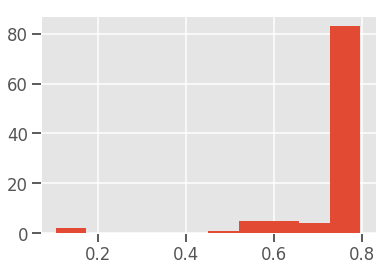

In [24]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score').mean_test_score.hist()

Catboost is a nonlinear model, so we lose explainability. Feature importances in tree models are commonly used to try to interpret them, but those may be biased by multicollinearity. Let's try to see what we get from them first:

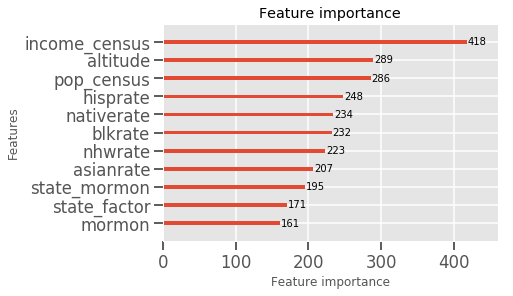

In [25]:
plot_importance(cat.best_estimator_)

Again, mormon comes as relatively not important

These feature importances may be fake news because of multicollinearity issues, so we turn to SHAP to see what features drive this model.

[SHAP](https://arxiv.org/pdf/1705.07874.pdf) produces a score for each pair of (feature,sample), indicating how much that feature contributed in that particular case. In effect SHAP is solving a credit assignment problem.

Unlike with the coefficients in OLS, here we have scores per pair of features, which make it more important to visualise what is going on on a case by case basis to see if trends emerge

In [26]:
import shap
shap.initjs()


In [27]:
explainer=shap.TreeExplainer(cat.best_estimator_)
shaps=explainer.shap_values(data[x3])

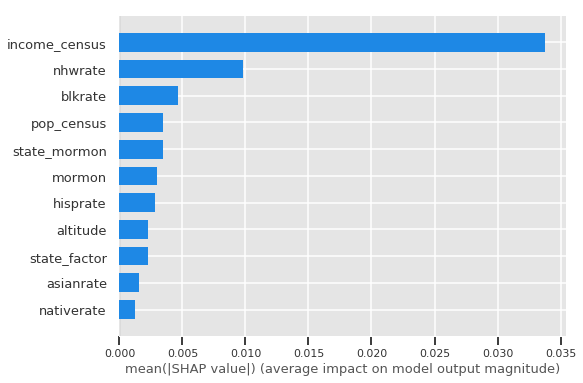

In [28]:
shap.summary_plot(shaps,data[x3], plot_type="bar")

Also in CatBoost, mormons are not a significant variable

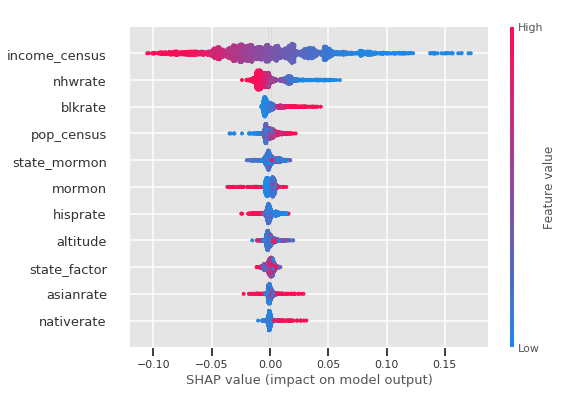

In [30]:
# This plot measures the impact of a variable on poverty. Each point is a particular county.
# The y-size of each row represents the density of points at that particular point
# High SHAP values mean in that case the variable in that case contributed to a higher poverty rate
# The sense in which it contributed can be glanced from the colorbar
# For example, the blue points in income_census mean that when income was low, the SHAP value was high (higher poverty)
# Positive values mean that in that part
shap.summary_plot(shaps,data[x3])

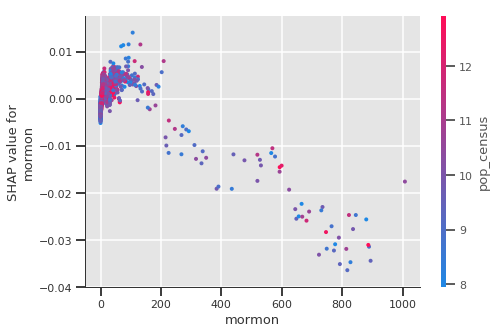

In [31]:
shap.dependence_plot("mormon", shaps,data[x3],interaction_index=0)

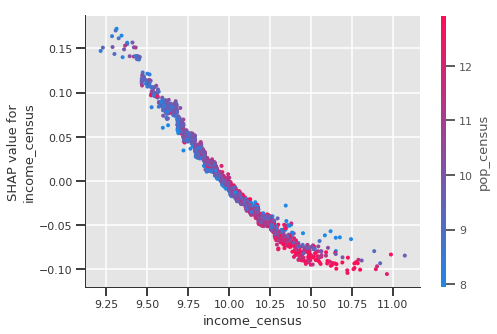

In [32]:
shap.dependence_plot("income_census", shaps,data[x3])

In [33]:
#Salt Lake
shap.force_plot(explainer.expected_value,shaps[2778,:],data[x3].loc[2778,:])

In [34]:
shap.force_plot(explainer.expected_value,shaps[217,:],data[x3].loc[217,:])

In [ ]:
data.query('county=="San Francisco"')

In [36]:
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     0.135936
baseline      0.137000
no_mormons    0.151743
diff          0.015807
dtype: float64

With catboost the effect is far less pronounced, just 0.016 percentage points.
But we manage to match very closely the real value, making this prediction more trustworthy

## Without income, on the residual

In [37]:
#Catboost on the residual of poverty~income
x4=x3[::1]
x4.remove('income_census')
cat_pos=np.where(data[x4].dtypes==int)[0].tolist()
cat_residual=get_bayes_tuner(cat_feat=cat_pos)
cat_residual.fit(data[x4],data[y2])


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.3s


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   10.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    9.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.7s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.3s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished


BayesSearchCV(cv=KFold(n_splits=20, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=6, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params={'categorical_feature': [9]}, iid=True, n_iter=100,
       n_jobs=2, n_points=1, optimizer_kwargs=None,
       pre_dispatch='2*n_jobs', random_state=42, refit=True,
       return_train_score=False, scoring='r2',
       search_spaces={'num_leaves': (10, 40), 'min_child_samples': (5, 50), 'learning_rate': (0.01, 0.5, 'uniform'), 'n_estimators': (10, 500), 'min_split_gain': (0.0, 1.0, 'uniform'), 'colsample_bytree': (0.5, 0.8, 1)},
       verbose=3)

In [38]:
cat_residual.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.01,
 'min_child_samples': 5,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'num_leaves': 40}

In [39]:
pd.DataFrame(cat_residual.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
17,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.034416,0.005747,0.000656,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
25,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.056534,0.005598,0.001472,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
23,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.183062,0.005700,0.001746,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
22,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.091684,0.005686,0.000904,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
21,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.061777,0.005858,0.001901,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
20,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.033133,0.005474,0.000628,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
19,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.033361,0.005422,0.000495,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
18,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.029606,0.005439,0.000661,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
16,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.034322,0.005860,0.000642,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
26,0.507187,0.493214,0.466580,0.339523,0.430132,0.338897,0.350341,0.557106,0.563937,0.493790,...,0.085108,0.005966,0.003056,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


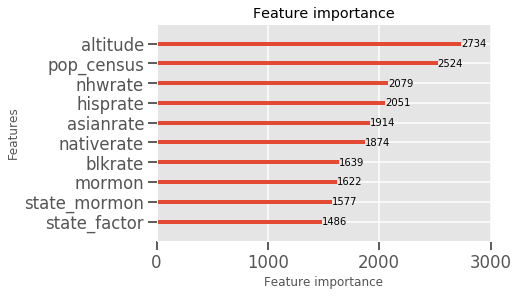

In [41]:
plot_importance(cat_residual.best_estimator_)
explainer=shap.TreeExplainer(cat_residual.best_estimator_)
shaps=explainer.shap_values(data[x4])

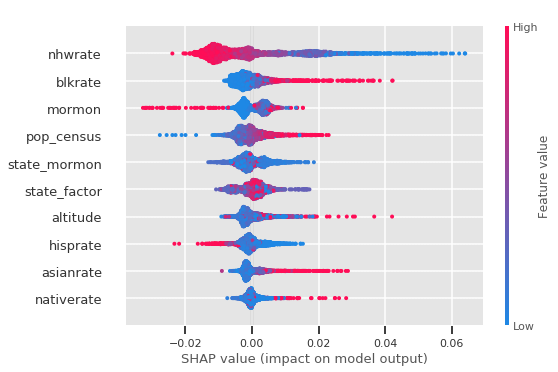

In [42]:
shap.summary_plot(shaps,data[x4])

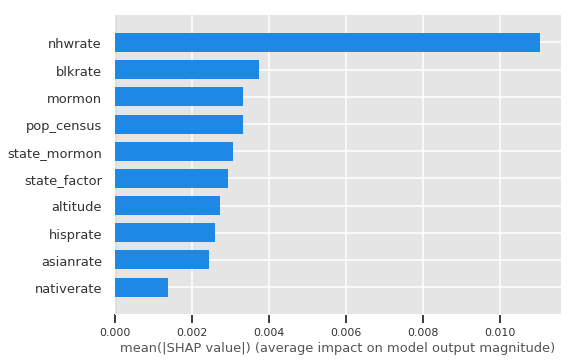

In [43]:
shap.summary_plot(shaps,data[x4],plot_type="bar")

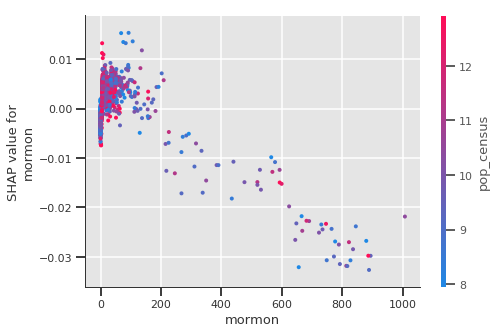

In [45]:
shap.dependence_plot("mormon", shaps,data[x4],interaction_index=0)

In [49]:
target = data.query('county=="Salt Lake"')[x4]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat_residual.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "counterf": cat_residual.predict(no_mormons)[0],
         "diff":-cat_residual.predict(target)[0]+cat_residual.predict(no_mormons)[0]
    }
)

predicted   -0.015210
baseline     0.137000
counterf    -0.005447
diff         0.009763
dtype: float64

Modeling just the residual leaves us with 0.01pp increase in poverty for Salt Lake City from the absence of mormons